# Introduction
This notebook perform the following tasks: 
 - Load and clean the data
 - Extract clean text data and perform LDA (Latent Dirishlet Allocation)
 - For each year, tag it with the respective topics and the respective topic proportion
 - Generate the trend plot for each topic
 - Perform sentiment analysis on the document level and distribute the sentiment scores among each topic based on the topic proportion
 - Generate the trend plot for both positive and negative sentiments for each topic

In addition, the notebook saves the following information either to files or a database table. These information will be needed by the web services:
 - Mapping from topic ID to topic name, which is a shown in the form of a mixture of word tokens with weights.
 - Annual topic popularity and the trend learned from a simple linear regression fitting
 - Annual topic sentiment scores and the trend learned from a simple linear regression fitting
 - The LDA model
 - Mapping from topics to documents with the scores

In [1]:
# Download the necessary nltk packages

import nltk
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhaoyiliang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/zhaoyiliang/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
# numpy is used for numerical operations
import numpy as np

# pandas is used for data manipulation and analysis
import pandas as pd

# string is used for string operations
import string

# nltk.corpus is used for the corpus of stop words and English words
from nltk.corpus import stopwords 
from nltk.corpus import words

# WordNetLemmatizer is used for lemmatizing words
from nltk.stem.wordnet import WordNetLemmatizer

# CoherenceModel and LdaModel are used for topic modeling
from gensim.models import CoherenceModel, LdaModel

# corpora is used for creating a corpus
from gensim import corpora

# datetime is used for date and time operations
from datetime import datetime

# LinearRegression is used for linear regression model
from sklearn.linear_model import LinearRegression

# FuncFormatter and pyplot are used for creating and customizing visualizations
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# defaultdict is used for creating a default dictionary
from collections import defaultdict

# Set up the stop words
# stopwords.words('english') returns a list of English stop words
stop = set(stopwords.words('english'))

# Add additional stop words
stop.add('also')
stop.add('could')

# Get a set of English words
english_words = set(words.words())

# Get a set of punctuation
exclude = set(string.punctuation)

# Instantiate a WordNetLemmatizer object from nltk.stem.wordnet
# This object will be used to lemmatize words, which is the process of reducing a word to its base or root form
lemma = WordNetLemmatizer()

## Load and clean the data 

In [3]:
def clean(doc: str) -> str:
    """
    This function cleans the input document by removing specific strings, 
    stop words, punctuation, non-English words, and lemmatizing the words.
    
    Parameters:
    doc (str): The input document to be cleaned.
    
    Returns:
    str: The cleaned document.
    """
    # Check if the input is a string
    if not isinstance(doc, str):
        return None
    
    # Remove specific strings from the document
    doc = doc.replace('Item 1.', '')
    doc = doc.replace('Item 1A.', '')
    doc = doc.replace('Item 7.', '')
    
    # Remove stop words from the document
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    
    # Remove punctuation from the document
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    
    # Keep only English words in the document
    english = " ".join(word for word in punc_free.split() if word in english_words)
    
    # Lemmatize the words in the document and remove words with length less than or equal to 3
    normalized = " ".join(lemma.lemmatize(word) for word in english.split() if len(word) > 3)
    
    return normalized

In [4]:
# Import the time module to measure the execution time
import time

# Record the start time
start_time = time.time()

# Load the csv file into a pandas DataFrame and drop the 'Unnamed: 0' column
df = pd.read_csv('all_filings_and_sections.csv').drop('Unnamed: 0', axis=1)

# Convert the 'filedAt' column to datetime format
df['filedAt_dt'] = df['filedAt'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z"))

# Extract the year and month from the 'filedAt_dt' column and create new columns for them
df['year'] = df['filedAt_dt'].apply(lambda x: x.year)
df['month'] = df['filedAt_dt'].apply(lambda x: x.month)

# Apply the clean function to the 'Section1', 'Section1A', and 'Section7' columns and create new columns for the cleaned text
df['Section1_clean'] = df['Section1'].apply(clean)
df['Section1A_clean'] = df['Section1A'].apply(clean)
df['Section7_clean'] = df['Section7'].apply(clean)

# Drop rows with missing values
df = df.dropna()

# Separate the cleaned sections into different variables
documents1, documents2, documents3 = df['Section1_clean'], df['Section1A_clean'], df['Section7_clean']

# Split the cleaned sections into lists of words
doc_clean1 = [doc.split() for doc in documents1] 
doc_clean2 = [doc.split() for doc in documents2] 
doc_clean3 = [doc.split() for doc in documents3] 

# Combine all the cleaned documents into one list
doc_clean = doc_clean1 + doc_clean2 + doc_clean3

# Calculate the execution time
execution_time = time.time() - start_time

# Print the execution time
print(f"The code executed in {execution_time} seconds")

The code executed in 159.35898804664612 seconds


## Extract clean text data and perform LDA (Latent Dirishlet Allocation)

In [5]:
# Record the start time
start = time.time()

# Set the number of topics
n = 12

# Create the term dictionary of our corpus, where every unique term is assigned an index. 
# This is done using the corpora.Dictionary function from the gensim library.
dictionary = corpora.Dictionary(doc_clean)

# Convert the list of documents (corpus) into a Document Term Matrix using the dictionary prepared above.
# The Document Term Matrix is a mathematical matrix that describes the frequency of terms that occur in the collection of documents.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Create the object for LDA model using gensim library
# LDA (Latent Dirichlet Allocation) is a generative statistical model that allows sets of observations to be explained by unobserved groups.
Lda = LdaModel

# Run and Train the LDA model on the document term matrix.
# num_topics specifies the number of latent topics to be extracted from the training corpus.
# id2word is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing.
# passes is the number of training passes through the corpus. For example, if the training corpus has 50,000 documents, chunksize is 10,000, passes is 2, then online training is done in 10 updates.
ldamodel = Lda(doc_term_matrix, num_topics=n, id2word=dictionary, passes=30)

# Calculate the execution time
execution_time = time.time() - start_time

# Print the execution time
print(f"The code executed in {execution_time} seconds")

# Print the topics
# num_topics is the number of topics to be returned. If None, all topics will be returned.
# num_words is the number of words to be presented for each topic. These words are the most representative words for each topic.
print(ldamodel.print_topics(num_topics=n, num_words=5))

# save the models
ldamodel.save('../models/lda.model')
dictionary.save('../models/dictionary.model')

The code executed in 750.665412902832 seconds
[(0, '0.025*"business" + 0.018*"financial" + 0.012*"adversely" + 0.012*"result" + 0.011*"affect"'), (1, '0.023*"product" + 0.020*"development" + 0.017*"clinical" + 0.011*"research" + 0.010*"regulatory"'), (2, '0.027*"natural" + 0.022*"production" + 0.012*"crude" + 0.010*"asset" + 0.010*"capital"'), (3, '0.013*"fuel" + 0.010*"aircraft" + 0.009*"vehicle" + 0.009*"service" + 0.009*"equipment"'), (4, '0.017*"data" + 0.013*"business" + 0.012*"revenue" + 0.011*"technology" + 0.010*"service"'), (5, '0.025*"risk" + 0.015*"capital" + 0.015*"financial" + 0.014*"credit" + 0.014*"insurance"'), (6, '0.015*"property" + 0.014*"real" + 0.014*"estate" + 0.012*"debt" + 0.012*"interest"'), (7, '0.109*"fiscal" + 0.015*"content" + 0.013*"store" + 0.012*"advertising" + 0.011*"retail"'), (8, '0.018*"company" + 0.013*"business" + 0.009*"president" + 0.009*"global" + 0.008*"product"'), (9, '0.039*"million" + 0.018*"income" + 0.017*"cash" + 0.014*"year" + 0.013*"ass

(0, '0.025*"business" + 0.018*"financial" + 0.012*"adversely" + 0.012*"result" + 0.011*"affect"')
(1, '0.023*"product" + 0.020*"development" + 0.017*"clinical" + 0.011*"research" + 0.010*"regulatory"')
(2, '0.027*"natural" + 0.022*"production" + 0.012*"crude" + 0.010*"asset" + 0.010*"capital"')
(3, '0.013*"fuel" + 0.010*"aircraft" + 0.009*"vehicle" + 0.009*"service" + 0.009*"equipment"')
(4, '0.017*"data" + 0.013*"business" + 0.012*"revenue" + 0.011*"technology" + 0.010*"service"')
(5, '0.025*"risk" + 0.015*"capital" + 0.015*"financial" + 0.014*"credit" + 0.014*"insurance"')
(6, '0.015*"property" + 0.014*"real" + 0.014*"estate" + 0.012*"debt" + 0.012*"interest"')
(7, '0.109*"fiscal" + 0.015*"content" + 0.013*"store" + 0.012*"advertising" + 0.011*"retail"')
(8, '0.018*"company" + 0.013*"business" + 0.009*"president" + 0.009*"global" + 0.008*"product"')
(9, '0.039*"million" + 0.018*"income" + 0.017*"cash" + 0.014*"year" + 0.013*"asset"')
(10, '0.035*"health" + 0.030*"care" + 0.021*"medic

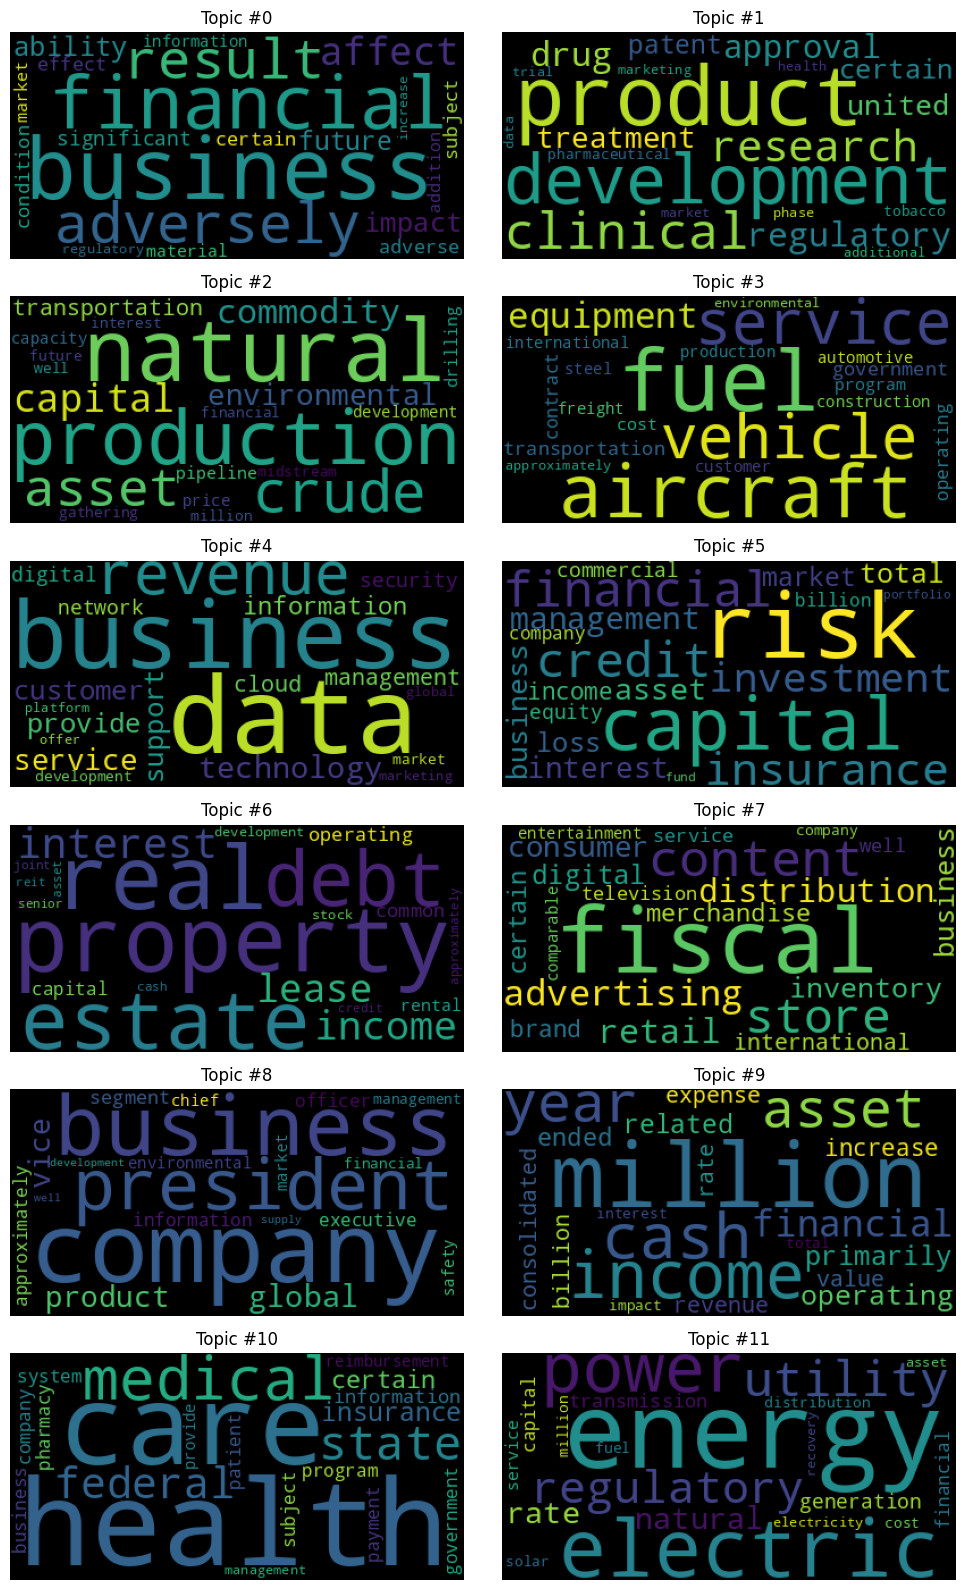

In [6]:
# Importing necessary libraries for word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Print the topics
# Here, we are using the print_topics method from the LDA model to print 12 topics with 5 words each
topics = ldamodel.print_topics(num_topics=n, num_words=5)

# Looping through each topic and printing it
for topic in topics:
    print(topic)

# Generate a word cloud for each topic
# Creating a subplot with 6 rows and 2 columns with a figure size of 10x16
fig, axes = plt.subplots(6, 2, figsize=(10, 16))  
axes = axes.flatten()  # Flattening the axes for easy iteration

# Looping through each topic
for i, topic in enumerate(topics):
    # Generating a word cloud for each topic using the fit_words method
    # The fit_words method takes a dictionary of words and their frequencies
    wordcloud = WordCloud().fit_words(dict(ldamodel.show_topic(i, 20)))
    # Displaying the word cloud on the respective axes
    axes[i].imshow(wordcloud)
    # Hiding the axes
    axes[i].axis("off")
    # Setting the title for each subplot as 'Topic #i'
    axes[i].set_title("Topic #" + str(i))

# Adjusting the layout for better visualization
plt.tight_layout()
# Displaying the plot
plt.show()

In [7]:
import pickle

# Save dictionary to a pickle file
topic_dict = {x[0]:x[1] for x in topics}
with open('../data/topics.pkl', 'wb') as f:
    pickle.dump(topic_dict, f)

In [8]:
# Perform a test inference
new_document = documents1[0]

# Preprocess the new document
new_text = [word for word in new_document.lower().split() if word not in stop]

# Create a new corpus
new_corpus = dictionary.doc2bow(new_text)

# Use the LDA model to get the topic
inferred_topics = ldamodel.get_document_topics(new_corpus)

# Print the topics
for topic in inferred_topics:
    print(f"Topic: {topics[topic[0]]}, Probability: {topic[1]}")

Topic: (0, '0.025*"business" + 0.018*"financial" + 0.012*"adversely" + 0.012*"result" + 0.011*"affect"'), Probability: 0.06283550709486008
Topic: (4, '0.017*"data" + 0.013*"business" + 0.012*"revenue" + 0.011*"technology" + 0.010*"service"'), Probability: 0.22002828121185303
Topic: (5, '0.025*"risk" + 0.015*"capital" + 0.015*"financial" + 0.014*"credit" + 0.014*"insurance"'), Probability: 0.35017699003219604
Topic: (8, '0.018*"company" + 0.013*"business" + 0.009*"president" + 0.009*"global" + 0.008*"product"'), Probability: 0.30094513297080994
Topic: (10, '0.035*"health" + 0.030*"care" + 0.021*"medical" + 0.013*"state" + 0.012*"federal"'), Probability: 0.053293876349925995


In [9]:
def getTopics(doc: str) -> list:
    """
    This function takes a document as input, preprocesses it, creates a new corpus, 
    and uses the LDA model to get the topics of the document.

    Parameters:
    doc (str): The document for which topics are to be extracted.

    Returns:
    topics (list): A list of topics extracted from the document.
    """
    # Preprocess the new document
    new_text = clean(doc).split()
    
    # Create a new corpus
    new_corpus = dictionary.doc2bow(new_text)
    
    # Use the LDA model to get the topic
    topics = ldamodel.get_document_topics(new_corpus)
    return topics

# Infer the topics for all the documents
df['topic1'] = df['Section1_clean'].apply(getTopics)
df['topic1A'] = df['Section1A_clean'].apply(getTopics)
df['topic7'] = df['Section7_clean'].apply(getTopics)

## What are the common themes mentioned in the sec filings? 
###  - Tag the year with the respective topics and the respective topic proportion
###  - Generate the trend plot for each topic
####  - Monthly analysis

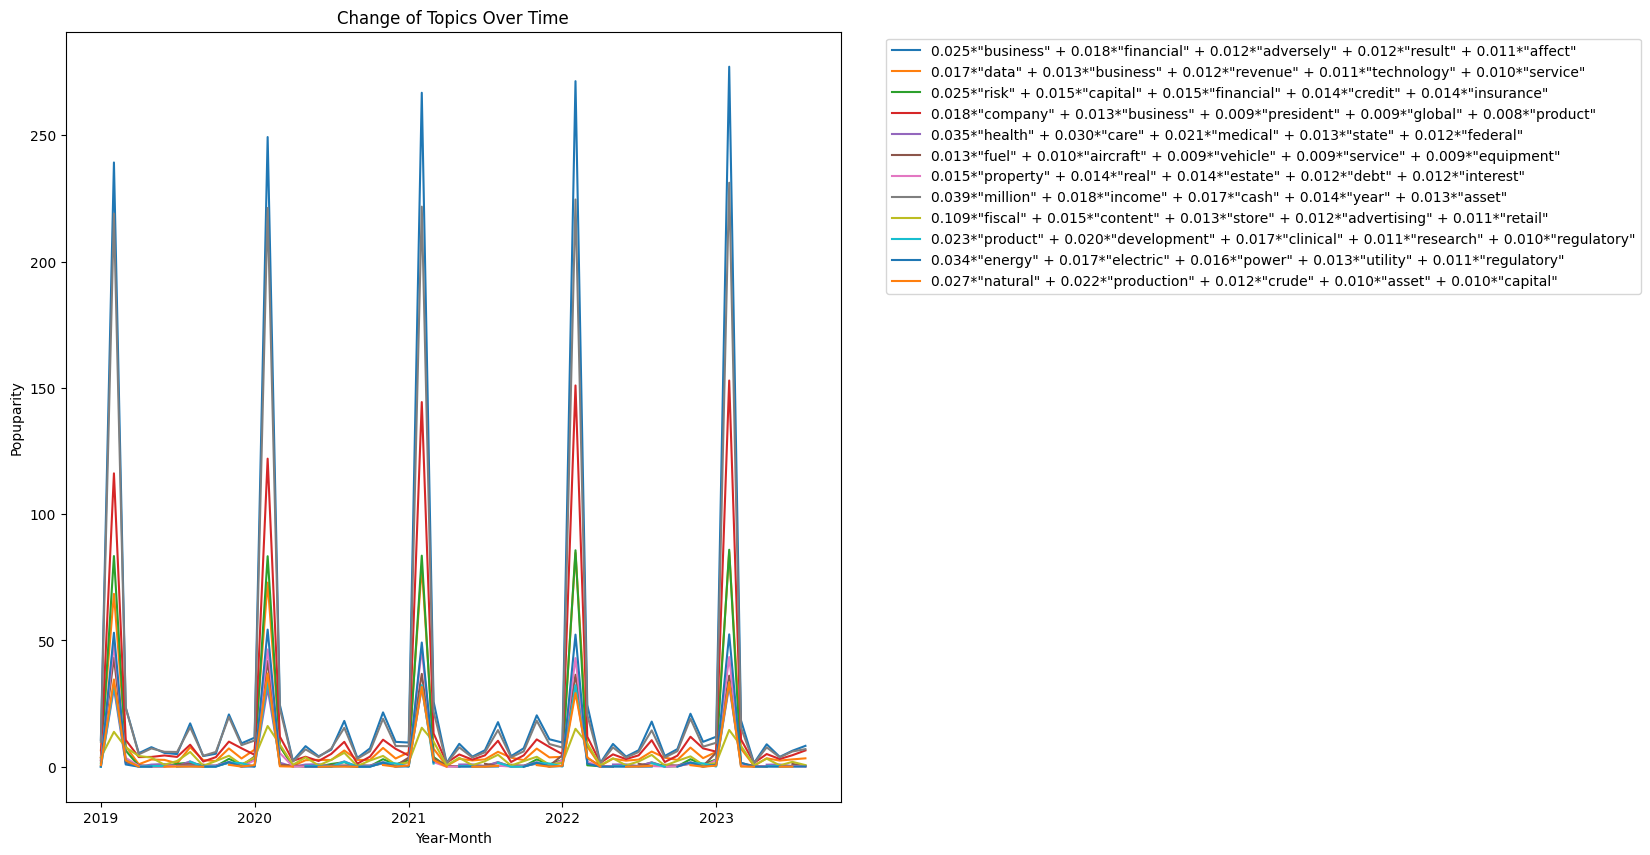

In [10]:
# Initialize a dictionary to store the sum of proportions for each topic in each year and month
# defaultdict is used to provide a default value for a nonexistent key
data = defaultdict(lambda: defaultdict(int))

# Iterate over the rows in the DataFrame
for _, row in df.iterrows():
    # For each topic and its proportion in 'topic1', 'topic1A', and 'topic7' columns, 
    # add the proportion to the corresponding topic in the corresponding year and month
    for topic, proportion in row['topic1']:
        data[(row['year'], row['month'])][topic] += proportion
    for topic, proportion in row['topic1A']:
        data[(row['year'], row['month'])][topic] += proportion
    for topic, proportion in row['topic7']:
        data[(row['year'], row['month'])][topic] += proportion

# Convert the dictionary to a DataFrame
# The .T method is used to transpose the DataFrame (swap rows and columns)
new_df = pd.DataFrame(data).T.reset_index()
# Rename the columns
new_df.columns = ['year', 'month'] + new_df.columns[2:].tolist()

# Sort the DataFrame by year and month
new_df.sort_values(by=['year', 'month'])

# Convert year and month to datetime for plotting
# The assign method is used to assign a new column 'day' with value 1
new_df['date'] = pd.to_datetime(new_df[['year', 'month']].assign(day=1))
# Sort the DataFrame by date in descending order
new_df.sort_values('date', ascending=False, inplace=True)
# Set the date as the index
new_df.set_index('date', inplace=True)

# Drop the year and month columns
new_df.drop(['year', 'month'], axis=1, inplace=True)

# Plot the data
# Create a new figure with a size of 10x6
plt.figure(figsize=(10, 10))
# For each column in the DataFrame, plot the data with the column name as the label
for column in new_df.columns:
    plt.plot(new_df.index, new_df[column], label=topic_dict[column])

# Set the labels and title of the plot
plt.xlabel('Year-Month')
plt.ylabel('Popuparity')
plt.title('Change of Topics Over Time')

# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Display the plot
plt.show()

It seems there is a seasonal cycle of all topics. As can be seen below, there are more filings in Feb and Mar, that's why there is a surge of all topic counts during these two months. 

In [11]:
df.month.value_counts()

month
2     1735
3      147
11      99
8       91
1       72
5       48
12      45
7       40
10      31
6       27
9       19
4       16
Name: count, dtype: int64

#### -  Yearly analysis

In [12]:
topic_dict

{0: '0.025*"business" + 0.018*"financial" + 0.012*"adversely" + 0.012*"result" + 0.011*"affect"',
 1: '0.023*"product" + 0.020*"development" + 0.017*"clinical" + 0.011*"research" + 0.010*"regulatory"',
 2: '0.027*"natural" + 0.022*"production" + 0.012*"crude" + 0.010*"asset" + 0.010*"capital"',
 3: '0.013*"fuel" + 0.010*"aircraft" + 0.009*"vehicle" + 0.009*"service" + 0.009*"equipment"',
 4: '0.017*"data" + 0.013*"business" + 0.012*"revenue" + 0.011*"technology" + 0.010*"service"',
 5: '0.025*"risk" + 0.015*"capital" + 0.015*"financial" + 0.014*"credit" + 0.014*"insurance"',
 6: '0.015*"property" + 0.014*"real" + 0.014*"estate" + 0.012*"debt" + 0.012*"interest"',
 7: '0.109*"fiscal" + 0.015*"content" + 0.013*"store" + 0.012*"advertising" + 0.011*"retail"',
 8: '0.018*"company" + 0.013*"business" + 0.009*"president" + 0.009*"global" + 0.008*"product"',
 9: '0.039*"million" + 0.018*"income" + 0.017*"cash" + 0.014*"year" + 0.013*"asset"',
 10: '0.035*"health" + 0.030*"care" + 0.021*"medic

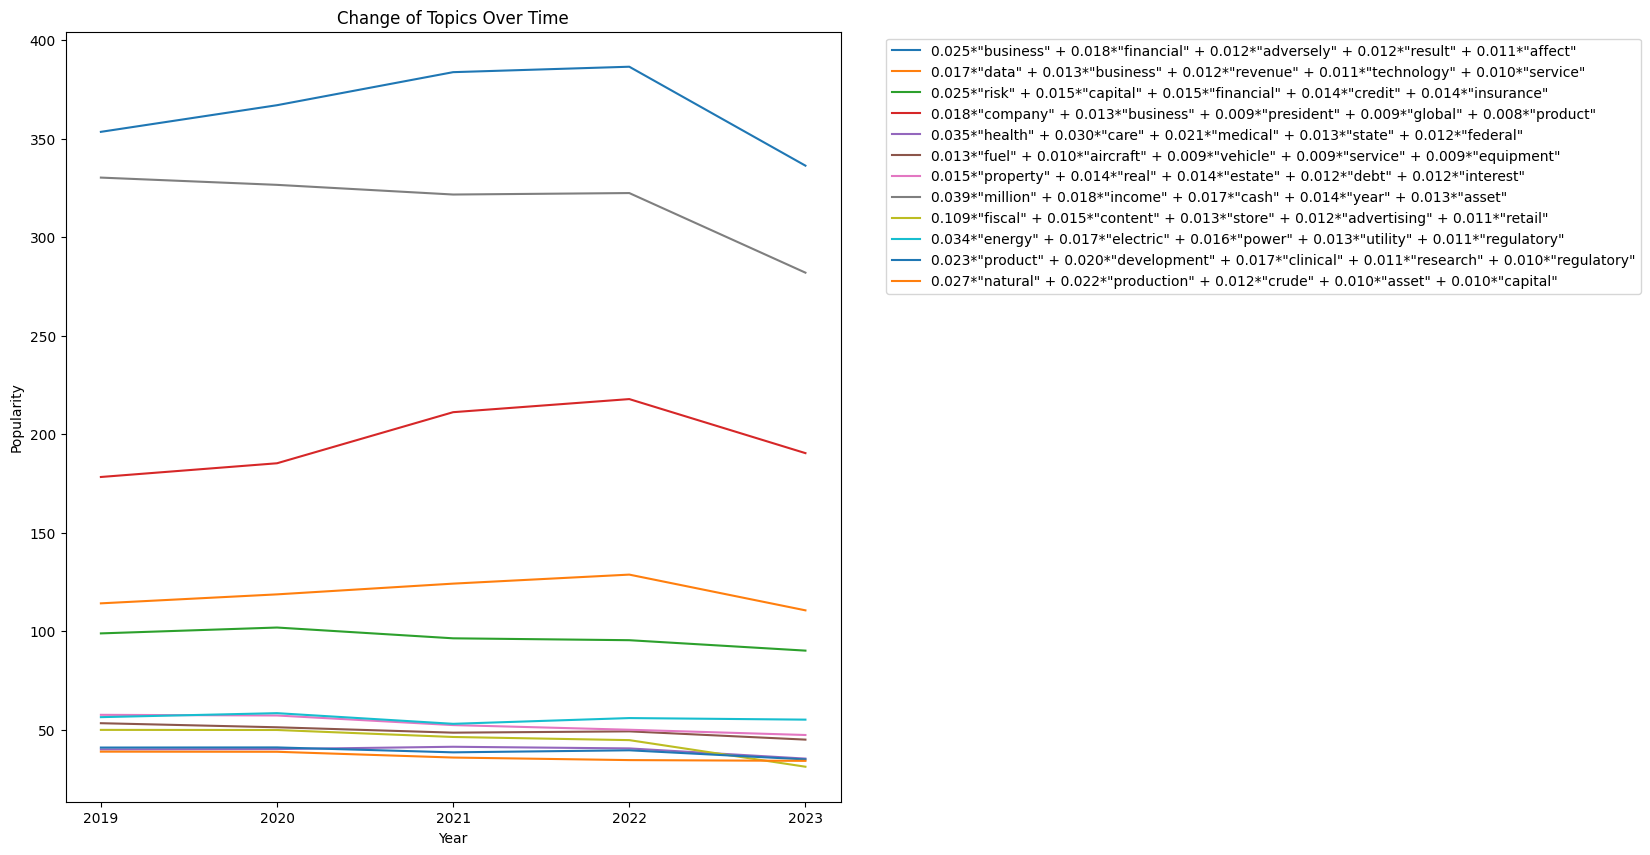

In [13]:
# Initialize a dictionary to store the sum of proportions for each topic in each year and month
# defaultdict is used to avoid KeyError when a new key is accessed
data = defaultdict(lambda: defaultdict(int))

# Iterate over the rows in the DataFrame
# Each row represents a document with topics and their proportions
for _, row in df.iterrows():
    # For each topic in 'topic1', 'topic1A', 'topic7' columns, add its proportion to the corresponding year in the data dictionary
    for topic, proportion in row['topic1']:
        data[row['year']][topic] += proportion
    for topic, proportion in row['topic1A']:
        data[row['year']][topic] += proportion
    for topic, proportion in row['topic7']:
        data[row['year']][topic] += proportion

# Print the topics
# ldamodel.print_topics prints the most significant topics
topics = ldamodel.print_topics(num_topics=n, num_words=5)

# Convert the dictionary to a DataFrame
# Transpose the DataFrame to make years as rows and topics as columns
new_df = pd.DataFrame(data).T.reset_index()
# Rename the columns
new_df.columns = ['year'] + new_df.columns[1:].tolist()

# Sort the DataFrame by year in ascending order
new_df.sort_values('year', ascending=True, inplace=True)
# Set the year as the index
new_df.set_index('year', inplace=True)

# Plot the data
# Create a new figure with specified size
plt.figure(figsize=(10, 10))
# For each topic, plot its proportions over years
for column in new_df.columns:
    plt.plot(new_df.index, new_df[column], label=topic_dict[column])

# Format the x-axis labels as integers
formatter = FuncFormatter(lambda x, pos: '%.0f' % x)
plt.gca().xaxis.set_major_formatter(formatter)

# Set labels and title for the plot
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.title('Change of Topics Over Time')

# Set the x-ticks
plt.xticks([2019, 2020, 2021, 2022, 2023])
# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

## What are the emerging themes over the last 5 years? And what are the declining themes?
#### - Compute the slope based on the yearly popularity scores

In [14]:
# Assuming time_series is a pandas Series
def compute_metrics(time_series: pd.Series) -> float:
    """
    Function to compute slope of a time series.

    Parameters:
    time_series (pd.Series): The time series data.

    Returns:
    float: The slope of the time series.
    """
    # Compute slope
    x = np.array(range(len(time_series))).reshape(-1, 1)
    y = time_series.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0]
    return np.round(slope, 8)[0]


# Initialize an empty dictionary to store the popularity of each topic
topic_popularity = {}

# Iterate over each column (topic) in the DataFrame
for col in new_df.columns:
    # Initialize a dictionary to store the popularity, trend and name of the topic
    value_obj = {}
    # Convert the column to a dictionary and round the values to 5 decimal places
    temp_dict = new_df[col].to_dict()
    value_obj['popularity'] = {k: round(v, 5) for k, v in temp_dict.items()}
    # Compute the standard deviation and slope of the topic's popularity over time
    slope = compute_metrics(new_df[col])
    # Store the slope (trend) in the dictionary
    value_obj['trend'] = slope
    # Store the name of the topic in the dictionary
    value_obj['name'] = topic_dict[col]
    # Add the dictionary to the main dictionary with the topic as the key
    topic_popularity[col] = value_obj

# Save the main dictionary to a pickle file for later use
# Pickle is a Python module used for serializing (converting Python objects into a byte stream) and de-serializing Python object structures
with open('../data/topic_popularity.pkl', 'wb') as f:
    pickle.dump(topic_popularity, f)

In [15]:
# Generate a list of emerging_topics and a list of declining_topics
emerging_topics = []
declining_topics = []

for col in new_df.columns:
    slope = compute_metrics(new_df[col])
    if slope > 0:
        emerging_topics.append((topic_dict[col], slope))
    else:
        declining_topics.append((topic_dict[col], slope))

print('emerging topic(s): ')
for t in emerging_topics:
    print(t)
print()
print('declining topic(s): ')
for t in declining_topics:
    print(t)

emerging topic(s): 
('0.017*"data" + 0.013*"business" + 0.012*"revenue" + 0.011*"technology" + 0.010*"service"', 0.29252987)
('0.018*"company" + 0.013*"business" + 0.009*"president" + 0.009*"global" + 0.008*"product"', 5.67964178)

declining topic(s): 
('0.025*"business" + 0.018*"financial" + 0.012*"adversely" + 0.012*"result" + 0.011*"affect"', -1.47933403)
('0.025*"risk" + 0.015*"capital" + 0.015*"financial" + 0.014*"credit" + 0.014*"insurance"', -2.39313678)
('0.035*"health" + 0.030*"care" + 0.021*"medical" + 0.013*"state" + 0.012*"federal"', -0.89836212)
('0.013*"fuel" + 0.010*"aircraft" + 0.009*"vehicle" + 0.009*"service" + 0.009*"equipment"', -1.87337886)
('0.015*"property" + 0.014*"real" + 0.014*"estate" + 0.012*"debt" + 0.012*"interest"', -2.7713879)
('0.039*"million" + 0.018*"income" + 0.017*"cash" + 0.014*"year" + 0.013*"asset"', -10.06692507)
('0.109*"fiscal" + 0.015*"content" + 0.013*"store" + 0.012*"advertising" + 0.011*"retail"', -4.2542923)
('0.034*"energy" + 0.017*"elec

The only emerging topic in the past 5 years is "business, development, global, president, technology".

## How was the sentiment changed across time for those emerging themes?
### - Perform sentiment analysis on the document level and distribute the sentiment scores among each topic based on the topic proportion

In [16]:
from textblob import TextBlob

def get_sentiment(text: str) -> float:
    """
    Function to compute the sentiment polarity of a text.

    Parameters:
    text (str): The text to analyze.

    Returns:
    float: The sentiment polarity of the text.
    """
    # Create a TextBlob object
    blob = TextBlob(text)
    # Return the sentiment polarity of the text
    return blob.sentiment.polarity

# Record the start time
start = time.time()

# Compute the sentiment polarity for each section in the DataFrame
# The apply function applies the get_sentiment function to each element in the specified columns
df['sentiment1'] = df['Section1_clean'].apply(get_sentiment)
df['sentiment1A'] = df['Section1A_clean'].apply(get_sentiment)
df['sentiment7'] = df['Section7_clean'].apply(get_sentiment)

# Compute the execution time
execution_time = time.time() - start
# Print the execution time
print(f"The code executed in {execution_time} seconds")

The code executed in 111.76091003417969 seconds


In [17]:
# Check the distribution of the sentiment for each filing document
df.describe()

,year,month,sentiment1,sentiment1A,sentiment7
count,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000
mean,2020.970464,3.192827,0.083383,0.064410,0.078604
std,1.394062,2.716744,0.036459,0.021675,0.029057
min,2019.000000,1.000000,-0.177868,-0.036575,-0.020026
25%,2020.000000,2.000000,0.064381,0.052689,0.066996
50%,2021.000000,2.000000,0.082746,0.064959,0.083210
75%,2022.000000,2.000000,0.103521,0.077321,0.097038
max,2023.000000,12.000000,0.250000,0.187500,0.185759


Majority of the document sentiments are positive.

#### - Generate the trend plot for both positive and negative sentiments for each topic

In [18]:
# Initialize a dictionary to store the sum of proportions for each topic in each year and month
data_pos = defaultdict(lambda: defaultdict(int))
data_neg = defaultdict(lambda: defaultdict(int))
data_count = defaultdict(lambda: defaultdict(int))

# Iterate over the rows in the DataFrame
for _, row in df.iterrows():
    for sentiment_key, topic_key in [('sentiment1', 'topic1'), ('sentiment1A', 'topic1A'), ('sentiment7', 'topic7')]:
        sentiment = row[sentiment_key]
        for topic, proportion in row[topic_key]:
            if sentiment > 0:
                data_pos[row['year']][topic] += (proportion * sentiment)
            else:
                data_neg[row['year']][topic] += (proportion * sentiment)
            data_count[row['year']][topic] += proportion

# Convert the dictionary to a DataFrame
new_df_pos = pd.DataFrame(data_pos).T.reset_index()
new_df_pos.columns = ['year'] + new_df_pos.columns[1:].tolist()

# Convert year and month to datetime for plotting
new_df_pos.sort_values('year', ascending=True, inplace=True)
# Set the date as the index
new_df_pos.set_index('year', inplace=True)
new_df_pos

,0,4,5,8,10,3,6,9,7,11,1,2
year,,,,,,,,,,,,
2019,23.710400,10.185394,5.656348,15.019693,2.812566,4.149476,4.178897,27.222556,4.282969,3.110417,3.199984,1.823765
2020,24.667885,10.603807,5.891725,15.506165,2.828256,4.019764,4.064955,26.652073,4.311144,3.144402,3.210943,1.908753
2021,25.906497,11.127358,5.840897,18.251746,3.130963,3.864068,3.753599,26.787567,4.071220,3.007120,3.118782,1.942637
2022,26.054375,11.638170,5.647717,19.376152,3.096868,4.025961,3.578427,27.564604,3.969868,3.309506,3.221226,1.901300
2023,22.140421,9.851162,5.380011,16.987753,2.691312,3.679303,3.349892,23.260300,2.715481,3.353485,2.819422,1.827010


In [19]:
# Convert the dictionary to a DataFrame
new_df_neg = pd.DataFrame(data_neg).T.reset_index()
new_df_neg.columns = ['year'] + new_df_neg.columns[1:].tolist()

# Convert year and month to datetime for plotting
new_df_neg.sort_values('year', ascending=True, inplace=True)
# Set the date as the index
new_df_neg.set_index('year', inplace=True)
new_df_neg

,5,11,0,1,2,3,4,6,7,8,9,10
year,,,,,,,,,,,,
2019,-0.001969,-0.034577,-0.024008,0.0,-0.351890,-0.042467,-0.001563,-0.005189,-0.000022,-0.059567,-0.012752,-0.000959
2020,-0.013831,-0.008402,-0.018239,0.0,-0.274806,-0.028183,-0.000491,-0.009379,-0.001381,-0.065958,-0.012813,0.000000
2021,-0.000428,-0.001996,-0.022866,0.0,-0.134003,-0.011717,-0.000464,-0.007966,0.000000,-0.041238,-0.014505,-0.001023
2022,-0.001560,-0.000383,-0.019086,0.0,-0.108827,-0.007673,-0.000285,-0.009359,0.000000,-0.038972,-0.010771,-0.000774
2023,-0.000884,-0.000277,-0.014471,0.0,-0.106292,-0.005521,-0.000629,-0.006144,0.000000,-0.038482,-0.005957,-0.000910


In [20]:
# Convert the dictionary to a DataFrame
new_df_cnt = pd.DataFrame(data_count).T.reset_index()
new_df_cnt.columns = ['year'] + new_df_cnt.columns[1:].tolist()

# Convert year and month to datetime for plotting
new_df_cnt.sort_values('year', ascending=True, inplace=True)
# Set the date as the index
new_df_cnt.set_index('year', inplace=True)
new_df_cnt

,0,4,5,8,10,3,6,9,7,11,1,2
year,,,,,,,,,,,,
2019,353.424911,114.092915,98.839328,178.229147,39.941950,53.250474,57.500569,330.198499,49.857355,56.325554,40.889057,38.816421
2020,366.945467,118.645501,101.812684,185.193046,40.106248,51.178049,57.162416,326.513711,49.804575,58.346675,40.956468,38.746211
2021,383.720615,124.098804,96.336939,211.125361,41.289648,48.448202,52.290591,321.606475,46.256274,52.934601,38.458450,35.817944
2022,386.479268,128.676279,95.381871,217.771101,40.453003,49.108585,49.927836,322.351521,44.658059,55.855245,39.500161,34.519623
2023,336.261341,110.540175,90.089051,190.338328,35.276762,44.918311,47.260919,281.944969,31.159151,55.060071,34.867186,34.139616


In [21]:
normalized_df_pos = new_df_pos / new_df_cnt
normalized_df_pos

,0,4,5,8,10,3,6,9,7,11,1,2
year,,,,,,,,,,,,
2019,0.067088,0.089273,0.057228,0.084272,0.070416,0.077924,0.072676,0.082443,0.085904,0.055222,0.078260,0.046984
2020,0.067225,0.089374,0.057868,0.083730,0.070519,0.078545,0.071112,0.081626,0.086561,0.053892,0.078399,0.049263
2021,0.067514,0.089665,0.060630,0.086450,0.075829,0.079757,0.071783,0.083293,0.088014,0.056808,0.081095,0.054236
2022,0.067415,0.090445,0.059212,0.088975,0.076555,0.081981,0.071672,0.085511,0.088895,0.059251,0.081550,0.055079
2023,0.065843,0.089118,0.059719,0.089250,0.076291,0.081911,0.070881,0.082499,0.087149,0.060906,0.080862,0.053516


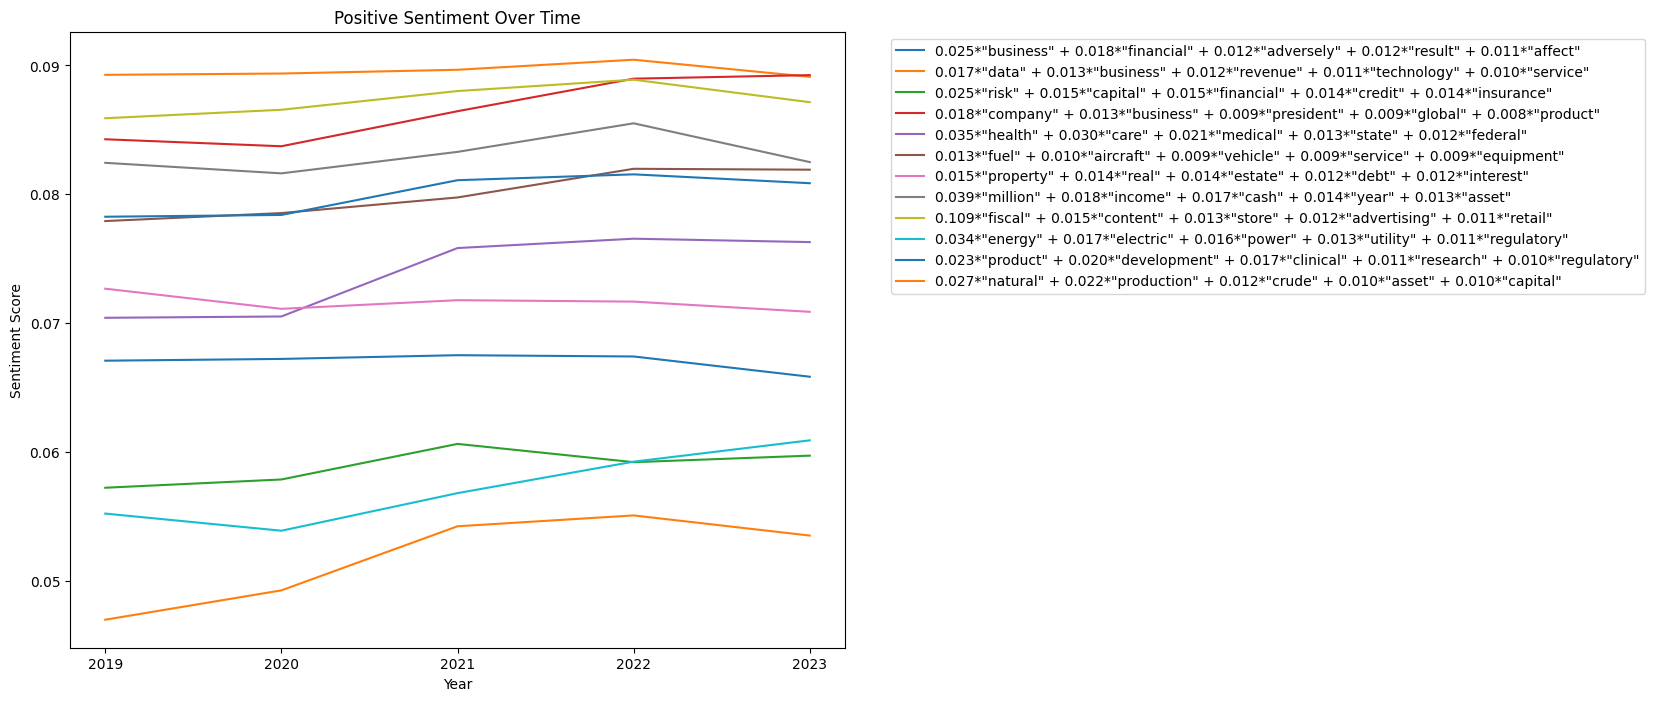

In [22]:
# Plot the data
plt.figure(figsize=(10, 8))
for column in normalized_df_pos.columns:
    plt.plot(normalized_df_pos.index, normalized_df_pos[column], label=topic_dict[column])

# Format the x-axis labels as integers
formatter = FuncFormatter(lambda x, pos: '%.0f' % x)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Positive Sentiment Over Time')
plt.xticks([2019, 2020, 2021, 2022, 2023])

# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [23]:
normalized_df_neg = new_df_neg / new_df_cnt
normalized_df_neg

,0,1,2,3,4,5,6,7,8,9,10,11
year,,,,,,,,,,,,
2019,-0.000068,0.0,-0.009065,-0.000797,-0.000014,-0.000020,-0.000090,-4.493080e-07,-0.000334,-0.000039,-0.000024,-0.000614
2020,-0.000050,0.0,-0.007092,-0.000551,-0.000004,-0.000136,-0.000164,-2.772426e-05,-0.000356,-0.000039,0.000000,-0.000144
2021,-0.000060,0.0,-0.003741,-0.000242,-0.000004,-0.000004,-0.000152,0.000000e+00,-0.000195,-0.000045,-0.000025,-0.000038
2022,-0.000049,0.0,-0.003153,-0.000156,-0.000002,-0.000016,-0.000187,0.000000e+00,-0.000179,-0.000033,-0.000019,-0.000007
2023,-0.000043,0.0,-0.003113,-0.000123,-0.000006,-0.000010,-0.000130,0.000000e+00,-0.000202,-0.000021,-0.000026,-0.000005


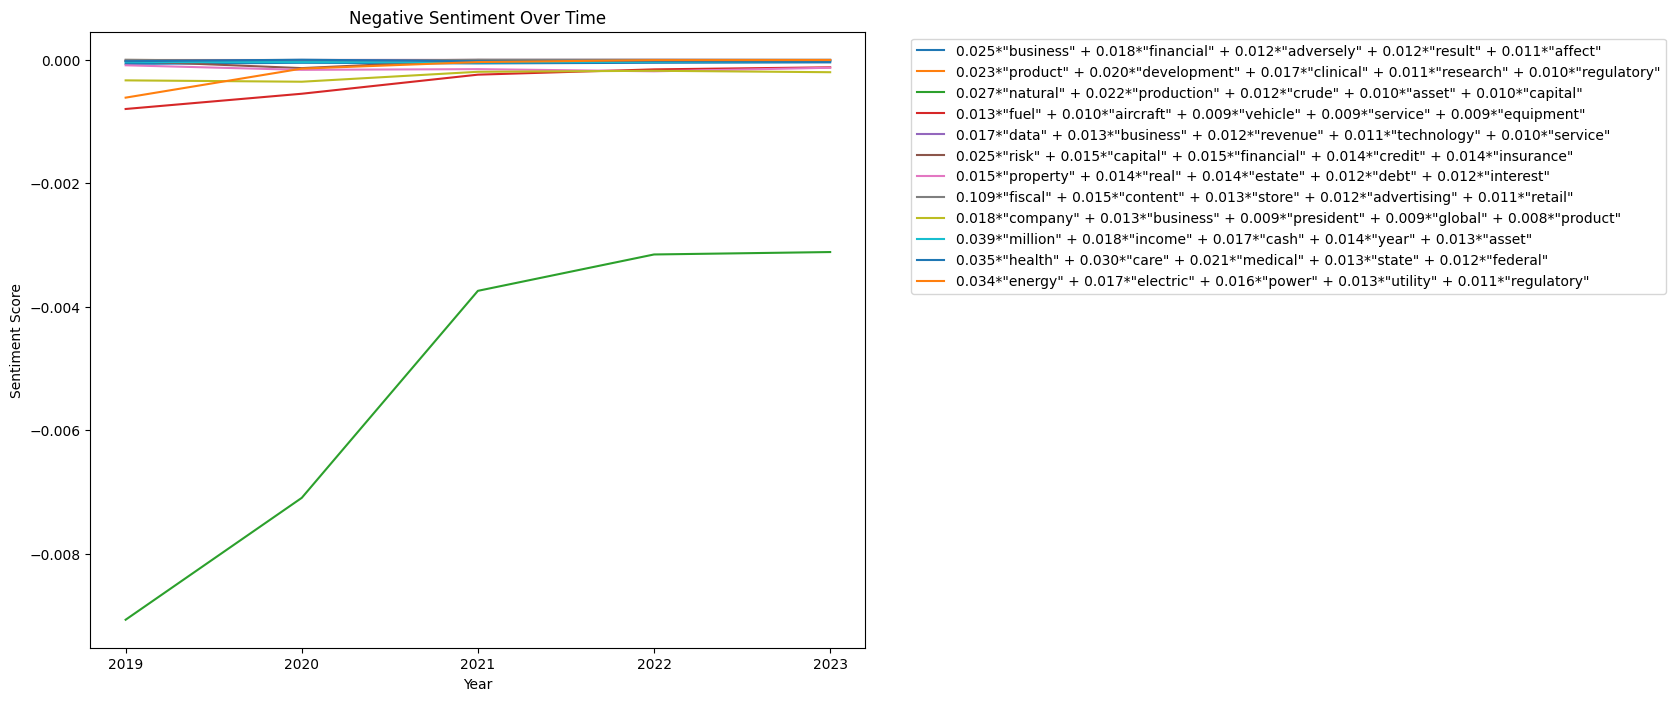

In [24]:
# Plot the data
plt.figure(figsize=(10, 8))
for column in normalized_df_neg.columns:
    plt.plot(normalized_df_neg.index, normalized_df_neg[column], label=topic_dict[column])

# Format the x-axis labels as integers
formatter = FuncFormatter(lambda x, pos: '%.0f' % x)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Negative Sentiment Over Time')
plt.xticks([2019, 2020, 2021, 2022, 2023])

# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The topic: "business, financial, adversely, result, affect becomes less negative in the past 5 years. The rest of the topics rarely have negative sentiments in the past 5 years.

In [25]:
# Initialize an empty dictionary to store the sentiment scores and trends for each topic
topic_sentiment = {}

# Iterate over the columns in the DataFrame of positive sentiment scores
for col in normalized_df_pos.columns:
    # Initialize a dictionary to store the sentiment scores and trends for the current topic
    value_obj = {}
    
    # Convert the column of positive sentiment scores to a dictionary
    temp_dict = normalized_df_pos[col].to_dict()
    
    # Store the positive sentiment scores in the dictionary, rounding to 5 decimal places
    value_obj['positive sentiment'] = {}
    value_obj['positive sentiment']['scores'] = {k: round(v, 5) for k, v in temp_dict.items()}
    
    # Compute the trend of the positive sentiment scores and store it in the dictionary
    slope = compute_metrics(normalized_df_pos[col])
    value_obj['positive sentiment']['trend'] = slope

    # Convert the column of negative sentiment scores to a dictionary
    temp_dict = normalized_df_neg[col].to_dict()
    
    # Store the negative sentiment scores in the dictionary, rounding to 5 decimal places
    value_obj['negative sentiment'] = {}
    value_obj['negative sentiment']['scores'] = {k: round(v, 5) for k, v in temp_dict.items()}
    
    # Compute the trend of the negative sentiment scores and store it in the dictionary
    slope = compute_metrics(normalized_df_neg[col])
    value_obj['negative sentiment']['trend'] = slope

    # Store the name of the current topic in the dictionary
    value_obj['name'] = topic_dict[col]
    
    # Add the dictionary for the current topic to the main dictionary
    topic_sentiment[col] = value_obj

# Save the main dictionary to a pickle file
with open('../data/topic_sentiment.pkl', 'wb') as f:
    pickle.dump(topic_sentiment, f)

### Create topic to document mapping and save the mapping into a database table

In [26]:
# Create a new DataFrame df1 by selecting 'companyName', 'filedAt', 'topic1' columns from the original DataFrame
df1 = df[['companyName', 'filedAt', 'topic1']].copy()
# Rename the columns of df1
df1.columns = ['companyName','filedAt', 'topics']
# Add a new column 'section' to df1 and set its value to 'Section1' for all rows
df1['section'] = 'Section1'

# Create a new DataFrame df2 by selecting 'companyName', 'filedAt', 'topic1A' columns from the original DataFrame
df2 = df[['companyName', 'filedAt', 'topic1A']].copy()
# Rename the columns of df2
df2.columns = ['companyName','filedAt', 'topics']
# Add a new column 'section' to df2 and set its value to 'Section1A' for all rows
df2['section'] = 'Section1A'

# Create a new DataFrame df3 by selecting 'companyName', 'filedAt', 'topic7' columns from the original DataFrame
df3 = df[['companyName', 'filedAt', 'topic7']].copy()
# Rename the columns of df3
df3.columns = ['companyName','filedAt', 'topics']
# Add a new column 'section' to df3 and set its value to 'Section7' for all rows
df3['section'] = 'Section7'

# Concatenate df1, df2, and df3 into a single DataFrame df_combined
df_combined = pd.concat([df1, df2, df3])

# Create a dictionary with 'companyName', 'filedAt', 'section' and all 'topic' + str(i) columns
data = {**{'companyName': df_combined['companyName'], 'filedAt': df_combined['filedAt'], 'section': df_combined['section']}, 
        **{'topic' + str(i): df_combined['topics'].apply(lambda x: dict(x).get(i, 0)) for i in range(n)}}

# Create a new DataFrame new_df from the dictionary
new_df = pd.DataFrame(data)

In [27]:
# Import the sqlite3 module for interacting with SQLite databases
import sqlite3

# Define the name of the table to be created in the SQLite database
table_name = 'document_topics'

# Establish a connection to the SQLite database
# If the database does not exist, it will be created
conn = sqlite3.connect('../mydb.sqlite')

# Define a SQL query to create a new table in the SQLite database
# The table will have columns for 'companyName', 'FiledAt', 'section', and 'topic0' to 'topic11'
# If the table already exists, the query will do nothing
query = f'''CREATE TABLE IF NOT EXISTS {table_name} (companyName text, FiledAt text, section text, topic0 real, topic1 real, topic2 real, 
            topic3 real, topic4 real, topic5 real, topic6 real, \
            topic7 real, topic8 real, topic9 real, topic10 real, topic11 real)'''

# Execute the SQL query
conn.execute(query)

# Write the contents of the DataFrame 'new_df' to the SQLite table
# If the table already exists, its contents will be replaced
new_df.to_sql(table_name,conn,if_exists='replace',index=False)

# Commit the current transaction
conn.commit()

# Close the connection to the SQLite database
conn.close()

In [28]:
# Test a simple DB query

# Establish a connection to the SQLite database
conn = sqlite3.connect('../mydb.sqlite')

# Define a SQL query to select 'companyName', 'filedAt', 'section', and 'topic0' from the table
# Only rows where 'topic0' is greater than 0.6 are selected
query = f'''SELECT companyName, filedAt, section, topic0 
            FROM {table_name} 
            WHERE topic0 > 0.6'''

# Execute the SQL query and store the response
response = conn.execute(query)

# Initialize an empty list to store the results
result = []

# Iterate over the rows in the response
for item in response:    
    # Create a dictionary for the current row
    # The dictionary contains 'name', 'filedAt', 'section', and 'score' keys
    # The values are extracted from the current row
    obj = {'name':item[0], 'filedAt':item[1], 'section':item[2], 'score':float(item[3])}
    
    # Append the dictionary to the list of results
    result.append(obj)

# Close the connection to the SQLite database
conn.close()